Purpose: To assess the utility of differentially expressed genes (DEGs) for the core stress project.<br>
Author: Anna Pardo<br>
Date initiated: June 9, 2023

In [125]:
# load modules
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from venn import venn

In [62]:
# set directory containing DESeq gene dataframes
directory = "../../data/DESeq_outputs"

In [6]:
os.listdir(directory)[0]

'PRJNA520822_DEG_df.txt'

In [69]:
# load each file in the directory as a dictionary entry
deg_dfs = {}
for i in range(len(os.listdir(directory))):
    df = pd.read_csv(directory+"/"+os.listdir(directory)[i],sep="\t",header="infer")
    k = os.listdir(directory)[i].strip().split("_")[0]
    deg_dfs[k] = df

In [25]:
deg_dfs.keys()

dict_keys(['PRJNA520822', 'PRJNA686250', 'PRJNA244661', 'PRJNA913846', 'PRJNA587226', 'PRJNA267717', 'PRJNA759701', 'PRJNA556806', 'PRJNA606824', 'PRJNA506720', 'PRJNA291919', 'PRJNA339768', 'PRJNA794297', 'PRJNA432945', 'PRJNA548548', 'PRJNA576545', 'PRJNA414300', 'PRJNA747925', 'PRJNA378714', 'PRJNA791560', 'PRJNA611589', 'PRJNA687609'])

In [28]:
# to aid with coding up contrasts, load metadata
md = pd.read_csv("../../data/metadata_ID_DE.csv",sep=",",header="infer")


In [60]:
mdb = md[md["BioProject"]=="PRJNA687609"]
mdb.head()

,BioProject,Sample,sample_name,Replicate_num,Genotype,Technology,Library_layout,Treatment,Duration_hours,Time_after_treatment,...,Tissue,Day_length_hours,Day_temp_C,Night_temp_C,Relative humidity (%),Light (umol/m2/s),Growth Env.,Media,Notes,identifier
1302,PRJNA687609,SRR13299751,NaN,1.0,Cim-3,Illumina HiSeq X Ten,PAIRED,Flooding,360.0,15 days,...,Leaf,NaN,NaN,NaN,NaN,NaN,Chamber,NaN,NaN,Cim-3_Flooding_360_NA_NA_V8_Leaf
1303,PRJNA687609,SRR13299752,NaN,1.0,Cim-3,Illumina HiSeq X Ten,PAIRED,Control,360.0,15 days,...,Leaf,NaN,NaN,NaN,NaN,NaN,Chamber,NaN,NaN,Cim-3_Control_360_NA_NA_V8_Leaf
1304,PRJNA687609,SRR13299753,NaN,2.0,Cim-3,Illumina HiSeq X Ten,PAIRED,Control,360.0,15 days,...,Leaf,NaN,NaN,NaN,NaN,NaN,Chamber,NaN,NaN,Cim-3_Control_360_NA_NA_V8_Leaf
1305,PRJNA687609,SRR13299754,NaN,3.0,Cim-3,Illumina HiSeq X Ten,PAIRED,Control,360.0,15 days,...,Leaf,NaN,NaN,NaN,NaN,NaN,Chamber,NaN,NaN,Cim-3_Control_360_NA_NA_V8_Leaf
1306,PRJNA687609,SRR13299759,NaN,2.0,Cim-3,Illumina HiSeq X Ten,PAIRED,Flooding,360.0,15 days,...,Leaf,NaN,NaN,NaN,NaN,NaN,Chamber,NaN,NaN,Cim-3_Flooding_360_NA_NA_V8_Leaf


In [61]:
mdb["identifier"].unique()

array(['Cim-3_Flooding_360_NA_NA_V8_Leaf',
       'Cim-3_Control_360_NA_NA_V8_Leaf',
       'Suwan-2_Flooding_360_NA_NA_V8_Leaf',
       'Suwan-2_Control_360_NA_NA_V8_Leaf'], dtype=object)

In [64]:
# for each BioProject in this dictionary, there is a list of acceptable contrasts to use
## hard code those lists into a dictionary here
## except for the set of BioProjects with low DEG counts, whose contrasts have been manually confirmed
contrasts = {
    "PRJNA520822":[
        "B73_Control_0_NA_NA_R1_Silk-V-B73_Heat_48_NA_NA_R1_Silk",
        "B73_Control_0_NA_NA_R1_Silk-V-B73_Heat_2_NA_NA_R1_Silk",
        "B73_Control_0_NA_NA_V3_Stalk-V-B73_Heat_2_NA_NA_V3_Stalk",
        "B73_Control_0_NA_NA_V3_Leaf-V-B73_Heat_48_NA_NA_V3_Leaf",
        "B73_Control_0_NA_NA_V3_Leaf-V-B73_Heat_2_NA_NA_V3_Leaf",
        "B73_Control_0_NA_NA_V3_Root-V-B73_Heat_48_NA_NA_V3_Root",
        "B73_Control_0_NA_NA_V3_Root-V-B73_Heat_2_NA_NA_V3_Root",
        "B73_Control_0_NA_NA_R1_Leaf-V-B73_Heat_48_NA_NA_R1_Leaf",
        "B73_Control_0_NA_NA_R1_Leaf-V-B73_Heat_2_NA_NA_R1_Leaf",
        "B73_Control_0_NA_NA_R1_Ear-V-B73_Heat_48_NA_NA_R1_Ear",
        "B73_Control_0_NA_NA_R1_Tassel-V-B73_Heat_48_NA_NA_R1_Tassel",
        "B73_Control_0_NA_NA_R1_Tassel-V-B73_Heat_2_NA_NA_R1_Tassel"
    ],
    "PRJNA244661":[
        "B37_Control_NA_NA_NA_14 days old_Leaf-V-B37_Cold_16_NA_NA_14 days old_Leaf",
        "B37_Control_NA_NA_NA_14 days old_Leaf-V-B37_Heat_4_NA_NA_14 days old_Leaf",
        "B73_Control_NA_NA_NA_14 days old_Leaf-V-B73_Cold_16_NA_NA_14 days old_Leaf",
        "B73_Control_NA_NA_NA_14 days old_Leaf-V-B73_Heat_4_NA_NA_14 days old_Leaf",
        "Oh43_Control_NA_NA_NA_14 days old_Leaf-V-Oh43_Cold_16_NA_NA_14 days old_Leaf",
        "Oh43_Control_NA_NA_NA_14 days old_Leaf-V-Oh43_Heat_4_NA_NA_14 days old_Leaf"
    ],
    "PRJNA913846":[
        "FR697_Control_48_NA_NA_Seedling_Root-V-FR697_Drought_48_NA_NA_Seedling_Root",
        "FR697_Control_24_NA_NA_Seedling_Root-V-FR697_Drought_24_NA_NA_Seedling_Root"
    ],
    "PRJNA267717":[
        "B73_Control_24_NA_NA_V2_Shoot-V-B73_Flooding_24_NA_NA_V2_Shoot",
        "B97_Control_24_NA_NA_V2_Shoot-V-B97_Flooding_24_NA_NA_V2_Shoot",
        "M162W_Control_24_NA_NA_V2_Shoot-V-M162W_Flooding_24_NA_NA_V2_Shoot",
        "Mo18W_Control_24_NA_NA_V2_Shoot-V-Mo18W_Flooding_24_NA_NA_V2_Shoot"
    ],
    "PRJNA759701":[
        "B73_Control_2_NA_NA_Germination_Embryo-V-B73_Cold_2_NA_NA_Germination_Embryo",
        "Mo17_Control_2_NA_NA_Germination_Embryo-V-Mo17_Cold_2_NA_NA_Germination_Embryo"
    ],
    "PRJNA556806":[
        "B104_Control_NA_NA_NA_4 days after sowing_Root-V-B104_Cold_NA_NA_NA_4 days after sowing_Root",
        "PE0002_Control_NA_NA_NA_4 days after sowing_Root-V-PE0002_Cold_NA_NA_NA_4 days after sowing_Root",
        "PE0019_Control_NA_NA_NA_4 days after sowing_Root-V-PE0019_Cold_NA_NA_NA_4 days after sowing_Root",
        "PE0022_Control_NA_NA_NA_4 days after sowing_Root-V-PE0022_Cold_NA_NA_NA_4 days after sowing_Root",
        "PE0026_Control_NA_NA_NA_4 days after sowing_Root-V-PE0026_Cold_NA_NA_NA_4 days after sowing_Root",
        "PE0040_Control_NA_NA_NA_4 days after sowing_Root-V-PE0040_Cold_NA_NA_NA_4 days after sowing_Root",
        "PE0055_Control_NA_NA_NA_4 days after sowing_Root-V-PE0055_Cold_NA_NA_NA_4 days after sowing_Root",
        "PE0075_Control_NA_NA_NA_4 days after sowing_Root-V-PE0075_Cold_NA_NA_NA_4 days after sowing_Root",
        "PE0099_Control_NA_NA_NA_4 days after sowing_Root-V-PE0099_Cold_NA_NA_NA_4 days after sowing_Root",
        "PE0100_Control_NA_NA_NA_4 days after sowing_Root-V-PE0100_Cold_NA_NA_NA_4 days after sowing_Root",
        "PE0159_Control_NA_NA_NA_4 days after sowing_Root-V-PE0159_Cold_NA_NA_NA_4 days after sowing_Root",
        "PE0161_Control_NA_NA_NA_4 days after sowing_Root-V-PE0161_Cold_NA_NA_NA_4 days after sowing_Root",
        "PE0265_Control_NA_NA_NA_4 days after sowing_Root-V-PE0265_Cold_NA_NA_NA_4 days after sowing_Root",
        "PE0323_Control_NA_NA_NA_4 days after sowing_Root-V-PE0323_Cold_NA_NA_NA_4 days after sowing_Root",
        "PE0328_Control_NA_NA_NA_4 days after sowing_Root-V-PE0328_Cold_NA_NA_NA_4 days after sowing_Root",
        "PE0334_Control_NA_NA_NA_4 days after sowing_Root-V-PE0334_Cold_NA_NA_NA_4 days after sowing_Root",
        "PE0345_Control_NA_NA_NA_4 days after sowing_Root-V-PE0345_Cold_NA_NA_NA_4 days after sowing_Root",
        "PE0349_Control_NA_NA_NA_4 days after sowing_Root-V-PE0349_Cold_NA_NA_NA_4 days after sowing_Root",
        "PE0359_Control_NA_NA_NA_4 days after sowing_Root-V-PE0359_Cold_NA_NA_NA_4 days after sowing_Root",
        "PE0420_Control_NA_NA_NA_4 days after sowing_Root-V-PE0420_Cold_NA_NA_NA_4 days after sowing_Root",
        "PE0440_Control_NA_NA_NA_4 days after sowing_Root-V-PE0440_Cold_NA_NA_NA_4 days after sowing_Root",
        "PE0485_Control_NA_NA_NA_4 days after sowing_Root-V-PE0485_Cold_NA_NA_NA_4 days after sowing_Root"
    ],
    "PRJNA291919":[
        "B73_Control_264_NA_NA_V12_Leaf-V-B73_Drought_264_NA_NA_V12_Leaf",
        "B73_Control_432_NA_NA_V14_Leaf-V-B73_Drought_432_NA_NA_V14_Leaf",
        "B73_Control_648_NA_NA_V18_Leaf-V-B73_Drought_648_NA_NA_V18_Leaf",
        "B73_Control_768_NA_NA_R1_Leaf-V-B73_Drought_768_NA_NA_R1_Leaf",
        "B73_Control_264_NA_NA_V12_Tassel-V-B73_Drought_264_NA_NA_V12_Tassel",
        "B73_Control_432_NA_NA_V14_Tassel-V-B73_Drought_432_NA_NA_V14_Tassel",
        "B73_Control_648_NA_NA_V18_Tassel-V-B73_Drought_648_NA_NA_V18_Tassel",
        "B73_Control_768_NA_NA_R1_Tassel-V-B73_Drought_768_NA_NA_R1_Tassel",
        "B73_Control_264_NA_NA_V12_Ear-V-B73_Drought_264_NA_NA_V12_Ear",
        "B73_Control_432_NA_NA_V14_Ear-V-B73_Drought_432_NA_NA_V14_Ear",
        "B73_Control_648_NA_NA_V18_Ear-V-B73_Drought_648_NA_NA_V18_Ear",
        "B73_Control_768_NA_NA_R1_Ear-V-B73_Drought_768_NA_NA_R1_Ear"
    ],
    "PRJNA794297":[
        "CM37_Control_168_NA_NA_V3_Leaf-V-CM37_Salt_168_300_300 mM_V3_Leaf",
        "cmh15_Control_168_NA_NA_V3_Leaf-V-cmh15_Salt_168_300_300 mM_V3_Leaf"
    ],
    "PRJNA576545":[
        "ND476_Control_288_NA_NA_45 days after germination_Leaf-V-ND476_Drought_288_NA_NA_45 days after germination_Leaf",
        "ZX978_Control_288_NA_NA_45 days after germination_Leaf-V-ZX978_Drought_288_NA_NA_45 days after germination_Leaf"
    ],
    "PRJNA414300":[
        "B46_Control_168_NA_NA_V1toV3_Leaf-V-B46_Salt_168_220_220 mM_V1toV3_Leaf",
        "NC236_Control_168_NA_NA_V1toV3_Leaf-V-NC236_Salt_168_220_220 mM_V1toV3_Leaf"
    ],
    "PRJNA747925":[
        "B73_Control_1_NA_NA_V2/V3_Leaf-V-B73_Cold_1_NA_NA_V2/V3_Leaf",
        "B73_Control_1_NA_NA_V2/V3_Leaf-V-B73_Heat_1_NA_NA_V2/V3_Leaf",
        "B73_Control_25_NA_NA_V2/V3_Leaf-V-B73_Cold_25_NA_NA_V2/V3_Leaf",
        "B73_Control_25_NA_NA_V2/V3_Leaf-V-B73_Heat_25_NA_NA_V2/V3_Leaf",
        "B73xMo17_Control_1_NA_NA_V2/V3_Leaf-V-B73xMo17_Cold_1_NA_NA_V2/V3_Leaf",
        "B73xMo17_Control_1_NA_NA_V2/V3_Leaf-V-B73xMo17_Heat_1_NA_NA_V2/V3_Leaf",
        "B73xMo17_Control_25_NA_NA_V2/V3_Leaf-V-B73xMo17_Cold_25_NA_NA_V2/V3_Leaf",
        "B73xMo17_Control_25_NA_NA_V2/V3_Leaf-V-B73xMo17_Heat_25_NA_NA_V2/V3_Leaf",
        "Mo17_Control_1_NA_NA_V2/V3_Leaf-V-Mo17_Cold_1_NA_NA_V2/V3_Leaf",
        "Mo17_Control_1_NA_NA_V2/V3_Leaf-V-Mo17_Heat_1_NA_NA_V2/V3_Leaf",
        "Mo17_Control_25_NA_NA_V2/V3_Leaf-V-Mo17_Cold_25_NA_NA_V2/V3_Leaf",
        "Mo17_Control_25_NA_NA_V2/V3_Leaf-V-Mo17_Heat_25_NA_NA_V2/V3_Leaf",
        "W22_Control_1_NA_NA_V2/V3_Leaf-V-W22_Cold_1_NA_NA_V2/V3_Leaf",
        "W22_Control_1_NA_NA_V2/V3_Leaf-V-W22_Heat_1_NA_NA_V2/V3_Leaf",
        "W22_Control_25_NA_NA_V2/V3_Leaf-V-W22_Cold_25_NA_NA_V2/V3_Leaf",
        "W22_Control_25_NA_NA_V2/V3_Leaf-V-W22_Heat_25_NA_NA_V2/V3_Leaf",
        "W22xB73_Control_1_NA_NA_V2/V3_Leaf-V-W22xB73_Cold_1_NA_NA_V2/V3_Leaf",
        "W22xB73_Control_1_NA_NA_V2/V3_Leaf-V-W22xB73_Heat_1_NA_NA_V2/V3_Leaf",
        "W22xB73_Control_25_NA_NA_V2/V3_Leaf-V-W22xB73_Cold_25_NA_NA_V2/V3_Leaf",
        "W22xB73_Control_25_NA_NA_V2/V3_Leaf-V-W22xB73_Heat_25_NA_NA_V2/V3_Leaf",
        "W22xMo17_Control_1_NA_NA_V2/V3_Leaf-V-W22xMo17_Cold_1_NA_NA_V2/V3_Leaf",
        "W22xMo17_Control_1_NA_NA_V2/V3_Leaf-V-W22xMo17_Heat_1_NA_NA_V2/V3_Leaf",
        "W22xMo17_Control_25_NA_NA_V2/V3_Leaf-V-W22xMo17_Cold_25_NA_NA_V2/V3_Leaf",
        "W22xMo17_Control_25_NA_NA_V2/V3_Leaf-V-W22xMo17_Heat_25_NA_NA_V2/V3_Leaf"
    ],
    "PRJNA791560":[
        "H39_1_Control_144_NA_NA_5 weeks old_Leaf-V-H39_1_Heat_144_NA_NA_5 weeks old_Leaf",
        "H39_1_Control_72_NA_NA_5 weeks old_Leaf-V-H39_1_Heat_72_NA_NA_5 weeks old_Leaf",
        "M189_Control_144_NA_NA_5 weeks old_Leaf-V-M189_Heat_144_NA_NA_5 weeks old_Leaf",
        "M189_Control_72_NA_NA_5 weeks old_Leaf-V-M189_Heat_72_NA_NA_5 weeks old_Leaf",
        "ZD309_Control_144_NA_NA_5 weeks old_Leaf-V-ZD309_Heat_144_NA_NA_5 weeks old_Leaf",
        "ZD309_Control_72_NA_NA_5 weeks old_Leaf-V-ZD309_Heat_72_NA_NA_5 weeks old_Leaf"
    ],
    "PRJNA611589":[
        "Ji853_Control_2_NA_NA_Germination_Embryo-V-Ji853_Cold_2_NA_NA_Germination_Embryo",
        "Zao8dash3_Control_2_NA_NA_Germination_Embryo-V-Zao8dash3_Cold_2_NA_NA_Germination_Embryo"
    ],
    "PRJNA687609":[
        "Cimdash3_Control_360_NA_NA_V8_Leaf-V-Cimdash3_Flooding_360_NA_NA_V8_Leaf",
        "Suwandash2_Control_360_NA_NA_V8_Leaf-V-Suwandash2_Flooding_360_NA_NA_V8_Leaf"
    ]
}

In [70]:
# make sure that each dataframe of DEGs is subsetted to only the relevant contrasts
degsub = {}
for k in deg_dfs.keys():
    if k in contrasts.keys():
        df = deg_dfs[k]
        df2 = df[df["Contrast"].isin(contrasts[k])]
        degsub[k] = df2
    else:
        degsub[k] = deg_dfs[k]

In [81]:
# for heat and cold, there are BioProjects that contain both: PRJNA244661 and PRJNA747925
# need to split these BioProjects up into (example) PRJNA244661_cold and PRJNA244661_heat (for each BioProject)
dsplit = {}
for k in degsub.keys():
    if k in ["PRJNA244661","PRJNA747925"]:
        df = degsub[k]
        cold = df[df["Contrast"].str.contains("Cold")]
        heat = df[df["Contrast"].str.contains("Heat")]
        dsplit[k+"_Cold"] = cold
        dsplit[k+"_Heat"] = heat
    else:
        dsplit[k] = degsub[k]

In [84]:
# specific objectives:
# 1. find out how many DEGs are present in each BioProject (as of 6/9 there are 22 present in the dataset)
# 2. split up the BioProjects by stressor and find out, within each stressor, how much overlap there is in DEGs
## start with number 1

ndeg = {}
for k in dsplit.keys():
    df = dsplit[k]
    up = df[df["log2FoldChange"]>0]
    down = df[df["log2FoldChange"]<0]
    ndeg[k] = {}
    ndeg[k]["Upregulated"] = len(up["GeneID"].unique())
    ndeg[k]["Downregulated"] = len(down["GeneID"].unique())

In [85]:
# make the dictionary into a dataframe
dfndeg = pd.DataFrame(ndeg).transpose().reset_index().rename(columns={"index":"BioProject"})

In [76]:
# load bioproject info
info = pd.read_csv("../../data/bioproject_info.csv",sep=",",usecols=["BioProject","Stressor"])
info.head()

,BioProject,Stressor
0,PRJNA172724,Drought
1,PRJNA210356,Dehydration
2,PRJNA234381,Salt
3,PRJNA244661,"Cold,Heat,Salt,UV"
4,PRJNA255755,Low Nitrogen


In [88]:
dfndeg

,BioProject,Upregulated,Downregulated
0,PRJNA520822,1554,1947
1,PRJNA686250,2,1
2,PRJNA244661_Cold,26,27
3,PRJNA244661_Heat,2229,4155
4,PRJNA913846,21,6
5,PRJNA587226,1,2
6,PRJNA267717,1932,2207
7,PRJNA759701,13,50
8,PRJNA556806,423,524
9,PRJNA606824,2,5


In [112]:
# merge with dfndeg
merged = dfndeg.merge(info,how="left")
merged.at[2,"Stressor"] = "Cold"
#merged.at[2,"BioProject"] = "PRJNA244661"
merged.at[3,"Stressor"] = "Heat"
#merged.at[3,"BioProject"] = "PRJNA244661"
merged.at[18,"Stressor"] = "Cold"
#merged.at[18,"BioProject"] = "PRJNA747925"
merged.at[19,"Stressor"] = "Heat"
#merged.at[19,"BioProject"] = "PRJNA747925"
merged.at[6,"Stressor"] = "Flooding"
merged.at[9,"Stressor"] = "Flooding"
merged.at[23,"Stressor"] = "Flooding"
merged

,BioProject,Upregulated,Downregulated,Stressor
0,PRJNA520822,1554,1947,Heat
1,PRJNA686250,2,1,Cold
2,PRJNA244661_Cold,26,27,Cold
3,PRJNA244661_Heat,2229,4155,Heat
4,PRJNA913846,21,6,Drought
5,PRJNA587226,1,2,Low Nitrogen
6,PRJNA267717,1932,2207,Flooding
7,PRJNA759701,13,50,Cold
8,PRJNA556806,423,524,Cold
9,PRJNA606824,2,5,Flooding


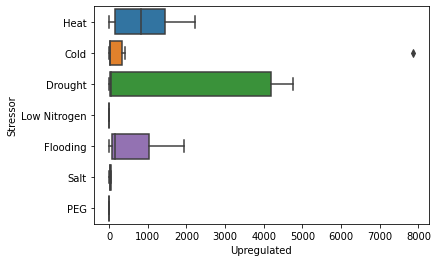

In [108]:
# plot a boxplot of DEGs (upregulated & downregulated) by stressor
sns.boxplot(y="Stressor",x="Upregulated",data=merged)
plt.savefig("../../figures/boxplot_upregulated_genes_09-Jun-2023.pdf")

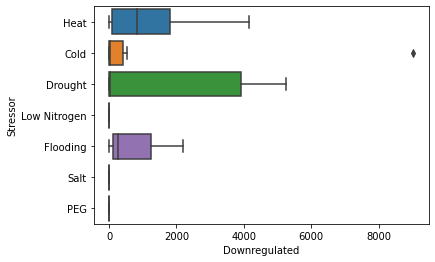

In [109]:
sns.boxplot(y="Stressor",x="Downregulated",data=merged)
plt.savefig("../../figures/boxplot_downregulated_genes_09-Jun-2023.pdf")

In [148]:
def set_dictionary(dictionary,df,k):
    dictionary["Upregulated_Genes"][k] = set(df[df["log2FoldChange"]>0]["GeneID"])
    dictionary["Downregulated_Genes"][k] = set(df[df["log2FoldChange"]<0]["GeneID"])

In [177]:
# now for step 2
# reminder of what step 2 is: split up the BioProjects by stressor and find out, 
## within each stressor, how much overlap there is in DEGs
# for this we need to go back to dsplit and make from it a dictionary of sets, and probably Venn diagrams
## first split up dsplit into one dictionary per stressor (exception: low nitrogen, which only has one BioProject right now)
## then add sets to these new dictionaries

cold = {"Upregulated_Genes":{},"Downregulated_Genes":{}}
heat = {"Upregulated_Genes":{},"Downregulated_Genes":{}}
drought = {"Upregulated_Genes":{},"Downregulated_Genes":{}}
pegdrought = {"Upregulated_Genes":{},"Downregulated_Genes":{}}
salt = {"Upregulated_Genes":{},"Downregulated_Genes":{}}
flooding = {"Upregulated_Genes":{},"Downregulated_Genes":{}}
for k in dsplit.keys():
    if k != "PRJNA548548":
        df = dsplit[k]
        x = merged[merged["BioProject"]==k]
        s = list(x["Stressor"])[0]
        if s == "Cold":
            if k.endswith("_Cold"):
                k = k.rstrip("_Cold")
            set_dictionary(cold,df,k)
        elif s == "Heat":
            if k.endswith("_Heat"):
                k = k.rstrip("_Heat")
            set_dictionary(heat,df,k)
        elif s == "Drought":
            set_dictionary(drought,df,k)
        elif s == "Salt":
            set_dictionary(salt,df,k)
        elif s == "Flooding":
            set_dictionary(flooding,df,k)
            
        if s in ["Drought","PEG"]:
            set_dictionary(pegdrought,df,k)
        

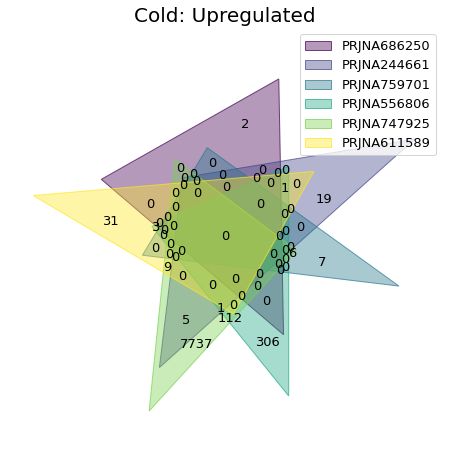

In [188]:
# start making venn diagrams
#plt.figure(figsize=(50,50))
venn(cold["Upregulated_Genes"])
plt.title("Cold: Upregulated",fontsize=20)
plt.savefig("../../figures/cold_upregulated_venn_09-Jun-2023.pdf")

Text(0.5, 1.0, 'Cold: Downregulated')

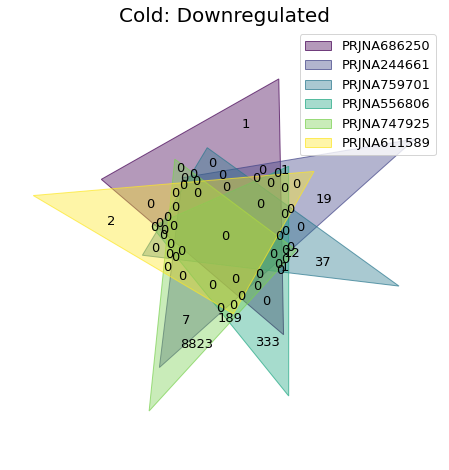

In [187]:
venn(cold["Downregulated_Genes"])
plt.title("Cold: Downregulated",fontsize=20)

Text(0.5, 1.0, 'Heat: Upregulated')

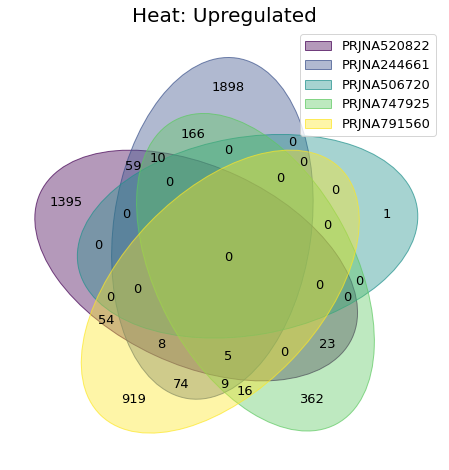

In [166]:
venn(heat["Upregulated_Genes"])
plt.title("Heat: Upregulated",fontsize=20)

Text(0.5, 1.0, 'Heat: Downregulated')

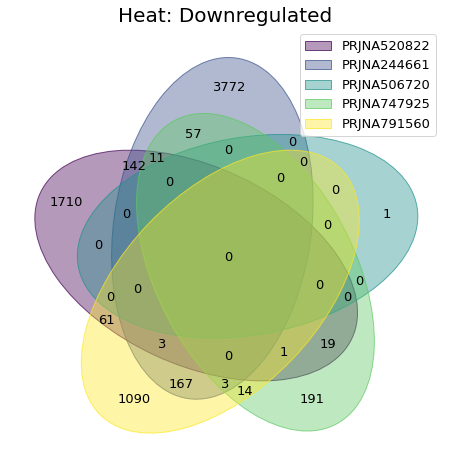

In [189]:
venn(heat["Downregulated_Genes"])
plt.title("Heat: Downregulated",fontsize=20)

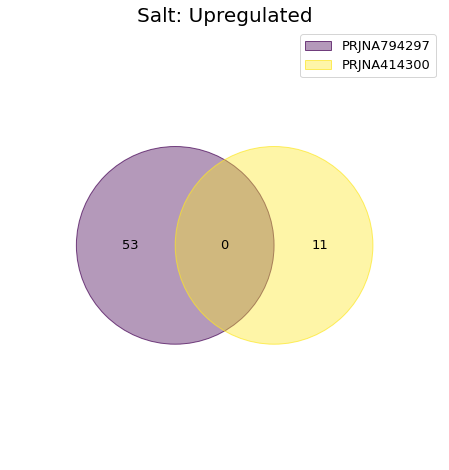

In [190]:
venn(salt["Upregulated_Genes"])
plt.title("Salt: Upregulated",fontsize=20)
plt.savefig("../../figures/salt_upregulated_venn_09-Jun-2023.pdf")

Text(0.5, 1.0, 'Salt: Downregulated')

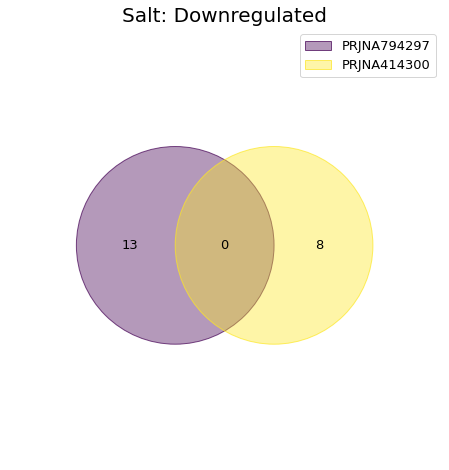

In [169]:
venn(salt["Downregulated_Genes"])
plt.title("Salt: Downregulated",fontsize=20)

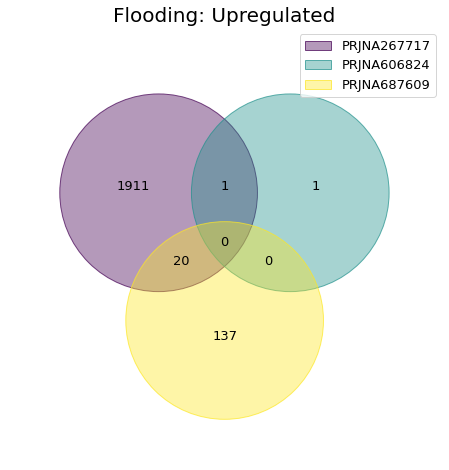

In [191]:
venn(flooding["Upregulated_Genes"])
plt.title("Flooding: Upregulated",fontsize=20)
plt.savefig("../../figures/flooding_upregulated_venn_09-Jun-2023.pdf")

Text(0.5, 1.0, 'Flooding: Downregulated')

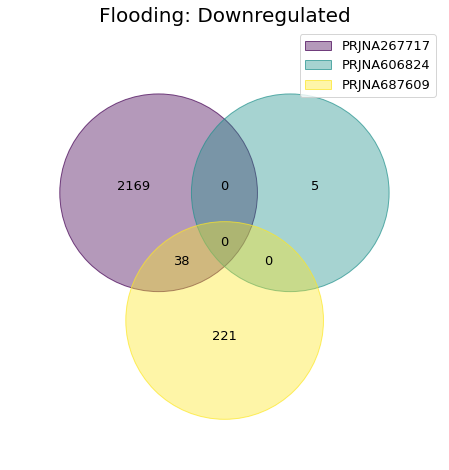

In [171]:
venn(flooding["Downregulated_Genes"])
plt.title("Flooding: Downregulated",fontsize=20)

Text(0.5, 1.0, 'Drought: Upregulated')

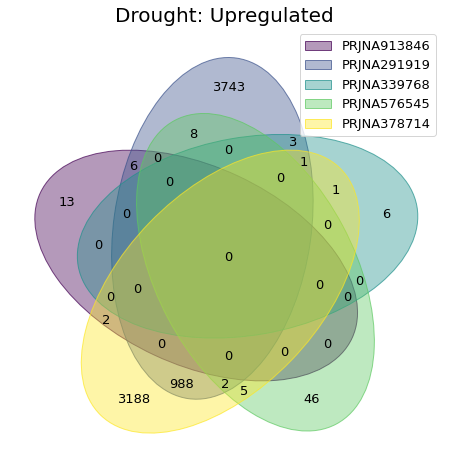

In [173]:
venn(drought["Upregulated_Genes"])
plt.title("Drought: Upregulated",fontsize=20)

Text(0.5, 1.0, 'Drought: Downregulated')

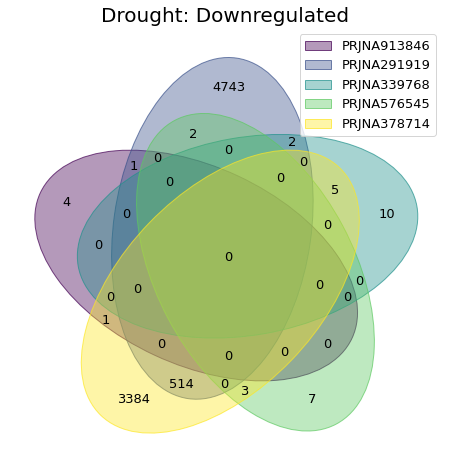

In [174]:
venn(drought["Downregulated_Genes"])
plt.title("Drought: Downregulated",fontsize=20)

Text(0.5, 1.0, 'PEG+Drought: Upregulated')

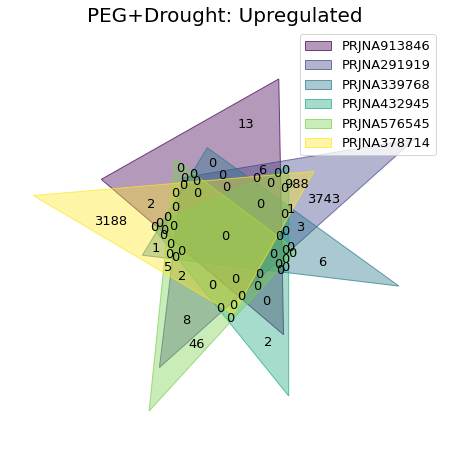

In [179]:
venn(pegdrought["Upregulated_Genes"])
plt.title("PEG+Drought: Upregulated",fontsize=20)

Text(0.5, 1.0, 'PEG+Drought: Downregulated')

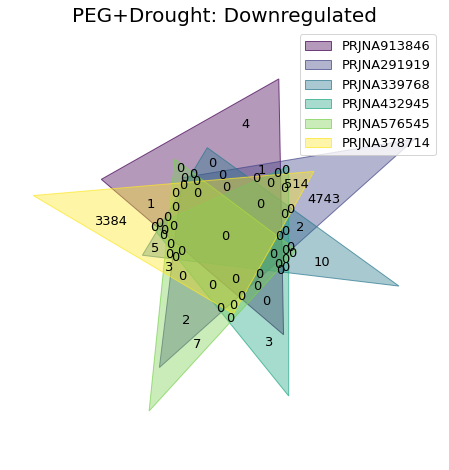

In [180]:
venn(pegdrought["Downregulated_Genes"])
plt.title("PEG+Drought: Downregulated",fontsize=20)